In [1]:
from torchvision import datasets
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch.nn as nn
import numpy as np
import torch
import time

## Global variables

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = 'dataset/'

## Loading train data

In [3]:
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images, tr_targets = fmnist.data, fmnist.targets

C:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Loading test data

In [4]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images, val_targets = val_fmnist.data, val_fmnist.targets

## Functions And Classes

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        return self.x[ix].to(device), self.y[ix].to(device)
    
    def __len__(self):
        return self.x.shape[0]

In [6]:
def get_model(optimizer_name):
    model = nn.Sequential(
                            nn.Linear(28 * 28, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 10)
                        ).to(device)
    loss_function = nn.CrossEntropyLoss()
    if optimizer_name == "Adam":
        optimizer = Adam(model.parameters(), lr=1e-2)
    else:
        optimizer = SGD(model.parameters(), lr=1e-2)
    
    return model, optimizer, loss_function

In [7]:
def train_batch(x, y, model, optimizer, loss_function):
    model.train()
    prediction = model(x)
    batch_loss = loss_function(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
def get_data():
    train_data = FMNISTDataset(tr_images, tr_targets)
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
    
    val_data = FMNISTDataset(val_images, val_targets)
    val_dataloader = DataLoader(val_data, batch_size=val_images.shape[0],shuffle=False)
    
    return train_dataloader, val_dataloader

In [10]:
@torch.no_grad()
def val_loss(x, y, model, loss_function):
    model.eval()
    prediction = model(x)
    val_loss = loss_function(prediction, y)
    return val_loss.item()

## Train with SGD

In [11]:
train_dataloader, val_dataloader = get_data()
model, optimizer, loss_function = get_model(optimizer_name='SGD')

In [12]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
start = time.time()
for epoch in range(1, 10 + 1):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_dataloader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_loss = val_loss(x, y, model, loss_function)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

end = time.time()
print(f"Time spent: {end - start}")

Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Time spent: 191.58665347099304


<ipython-input-13-40a81ada29c5>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{(x * 100):.0f}" for x in plt.gca().get_yticks()])


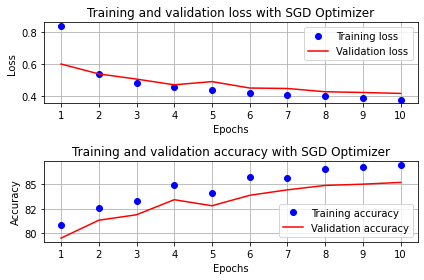

In [13]:
epochs = np.arange(10) + 1

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label="Training loss")
plt.plot(epochs, val_losses, 'r', label="Validation loss")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation loss with SGD Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid('off')

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label="Training accuracy")
plt.plot(epochs, val_accuracies, 'r', label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy with SGD Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels([f"{(x * 100):.0f}" for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')

plt.tight_layout();

## Train with Adam

In [14]:
train_dataloader, val_dataloader = get_data()
model, optimizer, loss_function = get_model(optimizer_name='Adam')

In [15]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
start = time.time()
for epoch in range(1, 10 + 1):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_dataloader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_loss = val_loss(x, y, model, loss_function)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

end = time.time()
print(f"Time spent: {end - start}")

Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Time spent: 206.3830122947693


<ipython-input-16-78ae05f67083>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"{(x * 100):.0f}" for x in plt.gca().get_yticks()])


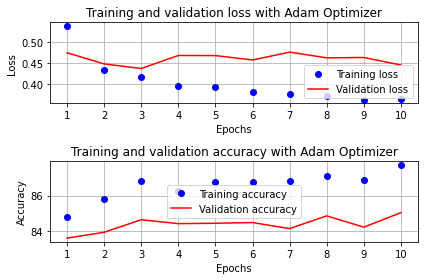

In [16]:
epochs = np.arange(10) + 1

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label="Training loss")
plt.plot(epochs, val_losses, 'r', label="Validation loss")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation loss with Adam Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid('off')

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label="Training accuracy")
plt.plot(epochs, val_accuracies, 'r', label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy with Adam Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels([f"{(x * 100):.0f}" for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')

plt.tight_layout();